# Data Analysis of the generated images and residuals without outliers

In this notebook, the dataset is generated with lenstronomy. The aim is to show the data used for the neural network and confirm if the generated data fits our expectations with simulated images.
As we deal with an absolute error on the residuals, some error percentage is tested to ensure that the error is difficult to see with the naked eye. 
Finally, the distribution of variable and labels is checked to ensure that our dataset building is correct.

The final configuration for the simulated images:
Lens' mass variation :
- Model: Power-law Elliptical Mass Distribution

>$\kappa = \frac{3-\gamma }{2}\left ( \frac{\theta_E}{\sqrt{q e_1^2+ e_2^2/q}} \right )^{\gamma-1}$
 
* Einstein radius: $\theta_E \in \mathcal{N}_{log}(\mu:0,\sigma:0.1)$

* Power law slope: $\gamma \in \mathcal{N}_{log}(\mu:0.7,\sigma:0.1)$
* Ellipsity* : $e_1 \in \mathcal{N}(\mu :0, \sigma : 0.2)$   and $e_2 \in \mathcal{N}(\mu :0, \sigma : 0.2)$
* Center : $x = 0$ and $y = 0$

Source variation :
* Model : Sersic ellipse
* Amplitude : $amp \in  \mathcal{U}(20, 24)$
* Sersic radius : $R_{sersic} \in  \mathcal{N}_{log}(\mu:-0.7,\sigma:0.4)$
* Sersic index : $n_{sersic} \in  \mathcal{N}_{log}(\mu:0.7,\sigma:0.4)$
* Ellipsity* : $e_1 \in \mathcal{U}(\mu :0, \sigma : 0.2)$   and $e_2 \in \mathcal{U}(\mu :0, \sigma : 0.2)$
* Center : $x \in \mathcal{U}(-0.5,0.5)$ and $y \in \mathcal{U}(-0.5,0.5)$

Note* : The ellipsity range is determined and is approximated with the following equations, where $q \in \mathcal{U}(0.7, 1)$ and $\phi \in \mathcal{U}(0, \frac{\pi}{2})$

>$e_1 = \frac{1-q}{1+q}\cos{(2\phi)}$     and     $e_2 = \frac{1-q}{1+q}\sin{(2\phi)} $
    
The added error is proportionally defined such that each quantity is defined as follows:

>$A_err = A \pm p A$

Where $A$ is the current quantity value and $p$ the user-defined percentage of error. 

The final data configuration parameters :
* Size of the whole dataset: $s = 6000$
* Ratio of error maps: $r = 75\%$
* Percentage of error : $p = \begin{bmatrix}5\% & 1.5\% & 5\%\end{bmatrix}$

In this data set, outliers are not considered: noise-like error residual maps and maps with a maximal absolute amplitude superior to $6$. The bound to remove the noise-like data in computing the Peak Signal-to-Noise Ratio (PSNR) between a map that does not contain any noise and any errors and compares it to the mean PSNR of maps only include noise. If the values are lower, the image is automatically discarded. Otherwise, the value is kept.

Mean square error :
>$MSE = \frac{1}{NM}\sum_{n= 0}^N \sum_{m=0}^M \left[ I_1(n,m) - I_2(n,m)\right]$


### 0. Import

In [1]:
import numpy as np
import pandas as pd
from statistics import mean
from scipy.stats import chi2, chi, gaussian_kde

from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation_chi2 import Residual, CombineDataset, LensDataset

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

### 1. Build the data set
The residual maps are generated and stored in the repository `data/dataset/` under the name `S[size]R[ratio]_lens.h5`, while the metadata is saved under the name `S[size]R[ratio]_meta.h5`. The `[size]` corresponds to the number of images, and the `[ratio]` is the percentage of error.

In [2]:
# Build the four classes 
size = 600; ratio = 0.75;
percent = np.array([0.005, 0.015, 0.005])
res = Residual()
res.build(size, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [3]:
str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)

print('Reading data Finished')

index = metadata.index

indices_noerror = index[[col == [0,0] for col in metadata['class']]]
indices_mass = index[[col == [1,0] for col in metadata['class']]]
indices_source = index[[col == [0,1] for col in metadata['class']]]
indices_masssource = index[[col == [1,1] for col in metadata['class']]]

Reading data Finished


## 2. Plot the residual maps and simulated images
#### Residual maps
We observe in the residual plot that maps that are noise-like and with obvious errors are no more contained in the final dataset.

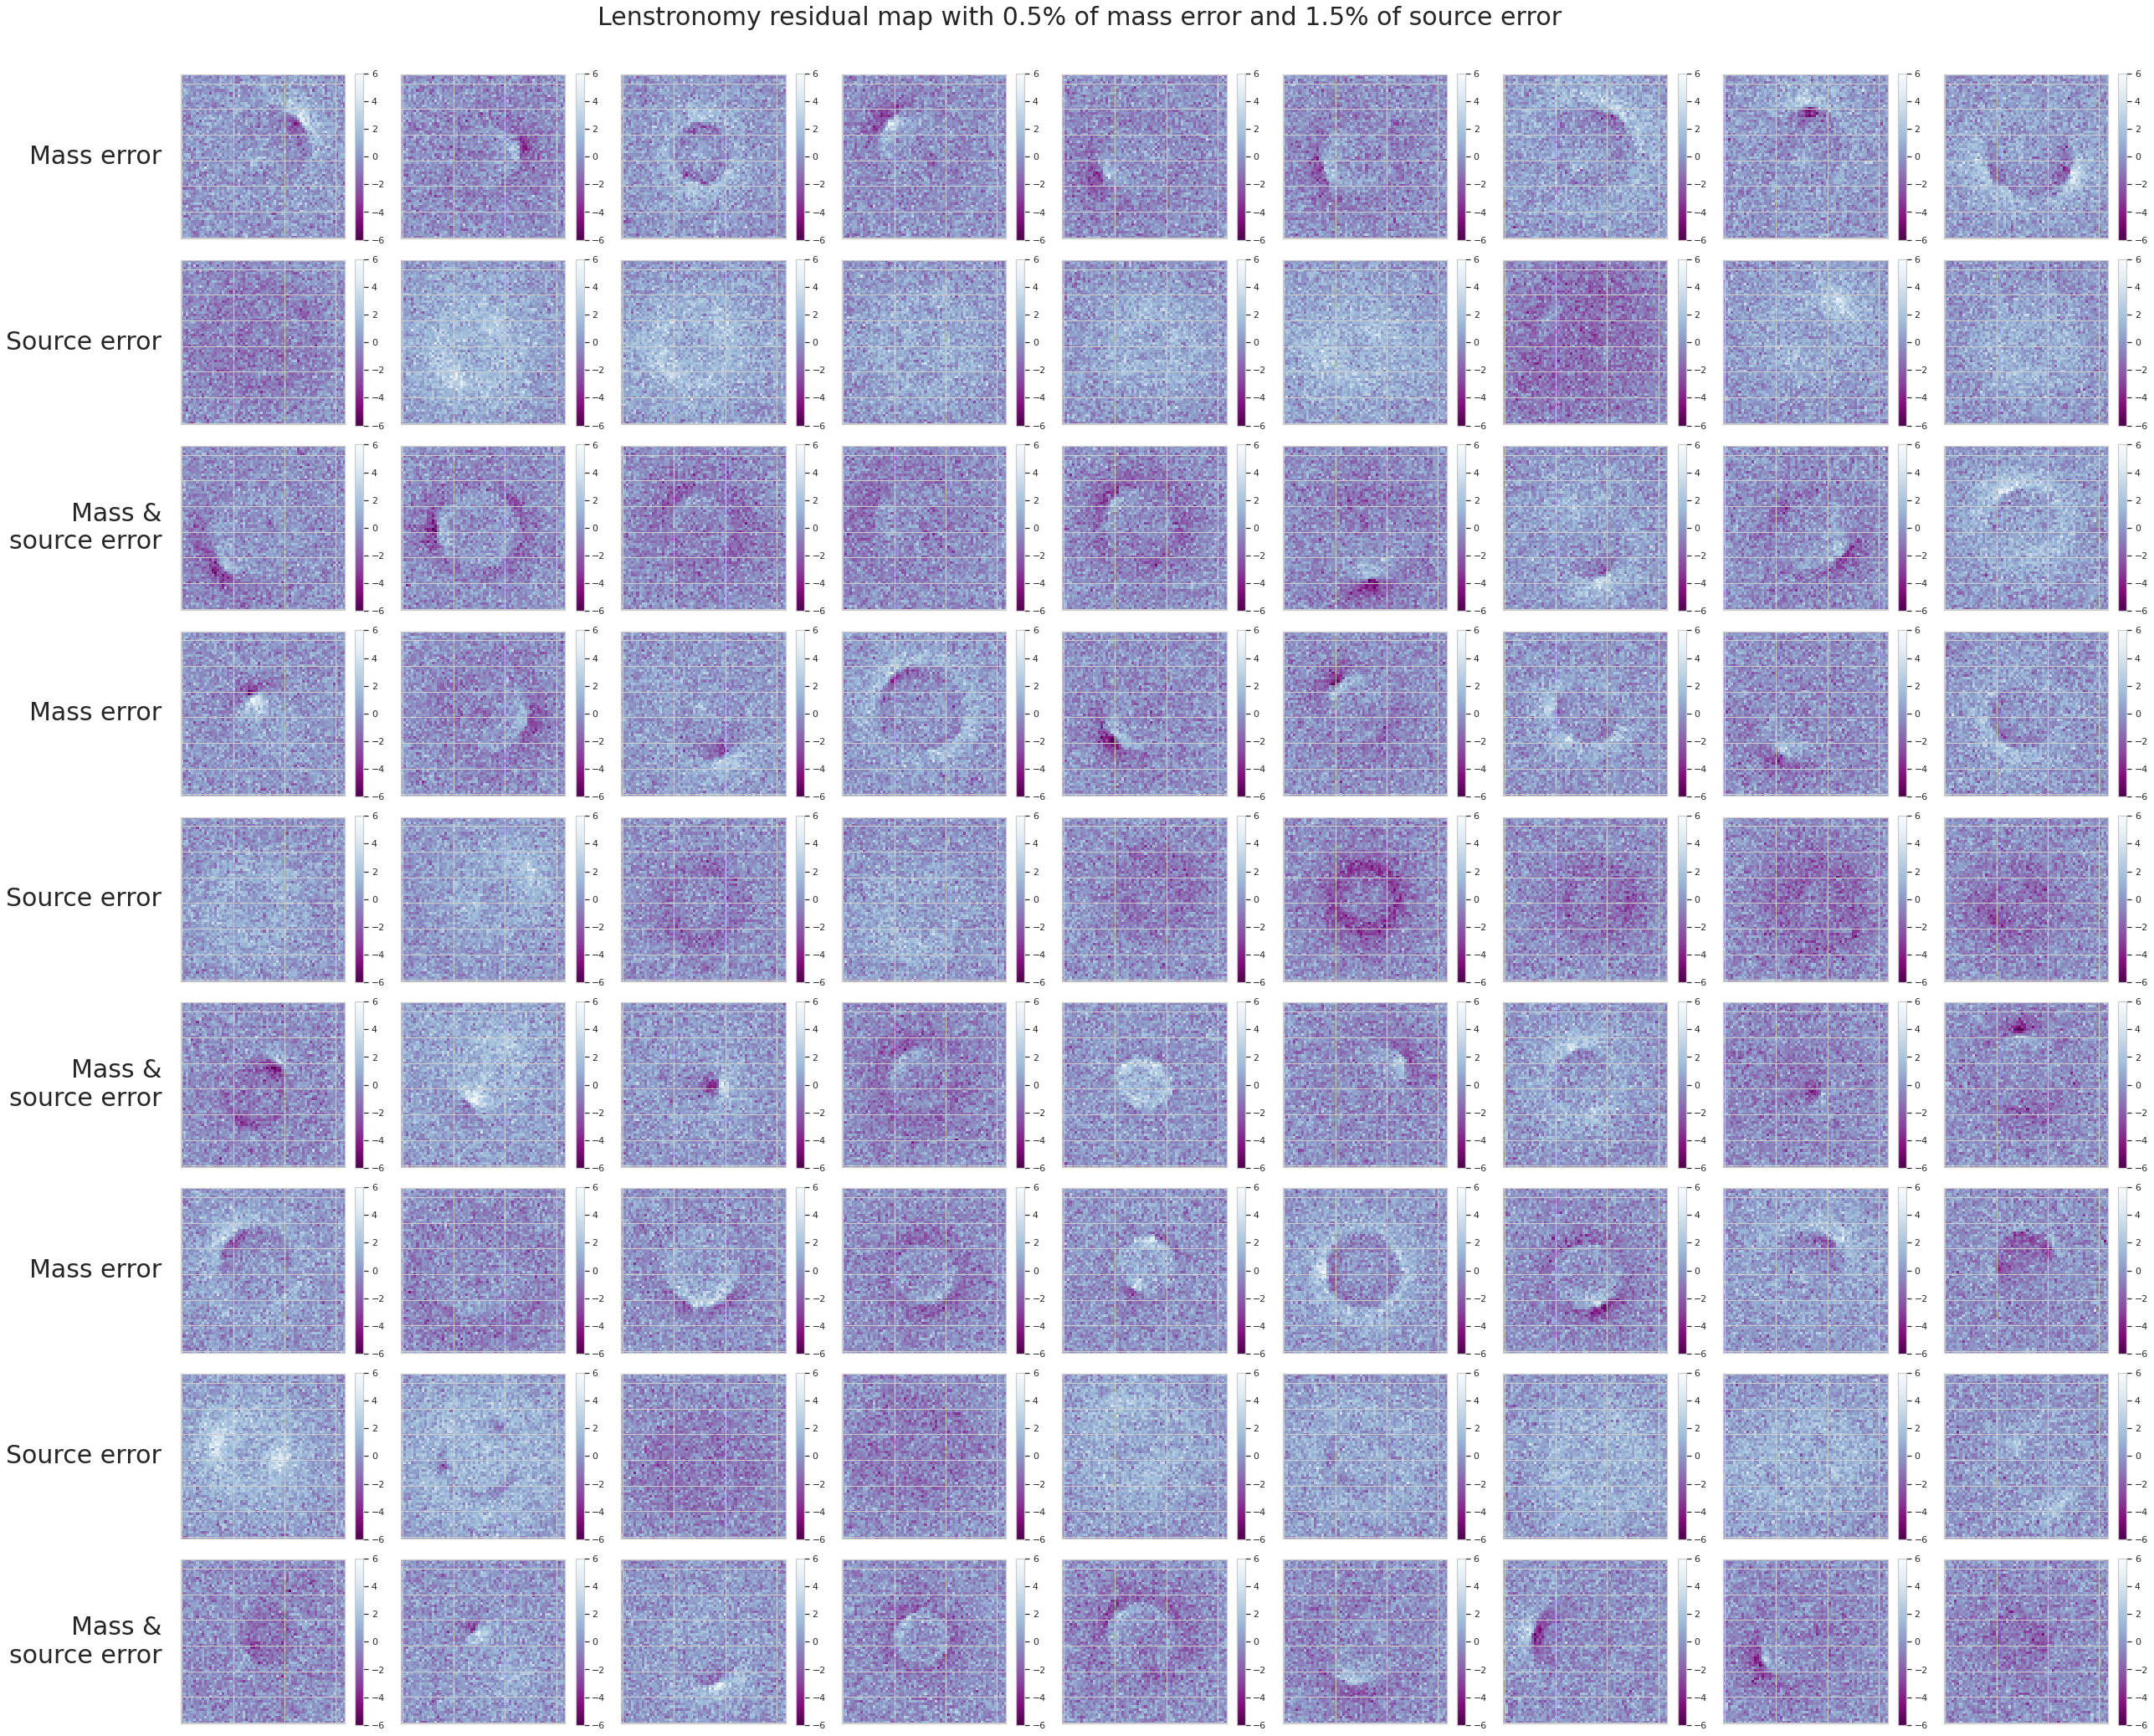

In [4]:
f, axes = plt.subplots(9, 9, figsize=(36, 30), sharex=False, sharey=False)

for count, k in enumerate(np.array([0, 3, 6])):
    for i in range(0,9):
        pos1 = axes[k,i].imshow(final_array[indices_mass[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
        pos2 = axes[k+1,i].imshow(final_array[indices_source[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
        pos3 = axes[k+2,i].imshow(final_array[indices_masssource[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)

        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        axes[k+1,i].set_yticklabels([]); axes[k+1,i].set_xticklabels([])
        axes[k+2,i].set_yticklabels([]); axes[k+2,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i]); f.colorbar(pos2, ax=axes[k+1,i])
        f.colorbar(pos3, ax=axes[k+2,i])
    
    
    pad = 5
    font = 30

    axes[k,0].annotate('Mass error', xy=(0, 0.5), xytext=(-axes[k,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+1,0].annotate('Source error', xy=(0, 0.5), xytext=(-axes[k+1,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+1,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+2,0].annotate('Mass &\nsource error', xy=(0, 0.5), xytext=(-axes[k+2,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+2,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    
f.suptitle('Lenstronomy residual map with {:.1f}% of mass error and {:.1f}% of source error'.format(percent[0]*100, percent[1]*100), size = 'large',fontsize=font)
plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

plt.show()
f.savefig('figures/datanalysis/'+str(int(percent[0]*100))+'percenterror_chi2.jpeg')

#### Auto-correlation of the previously showed residual maps

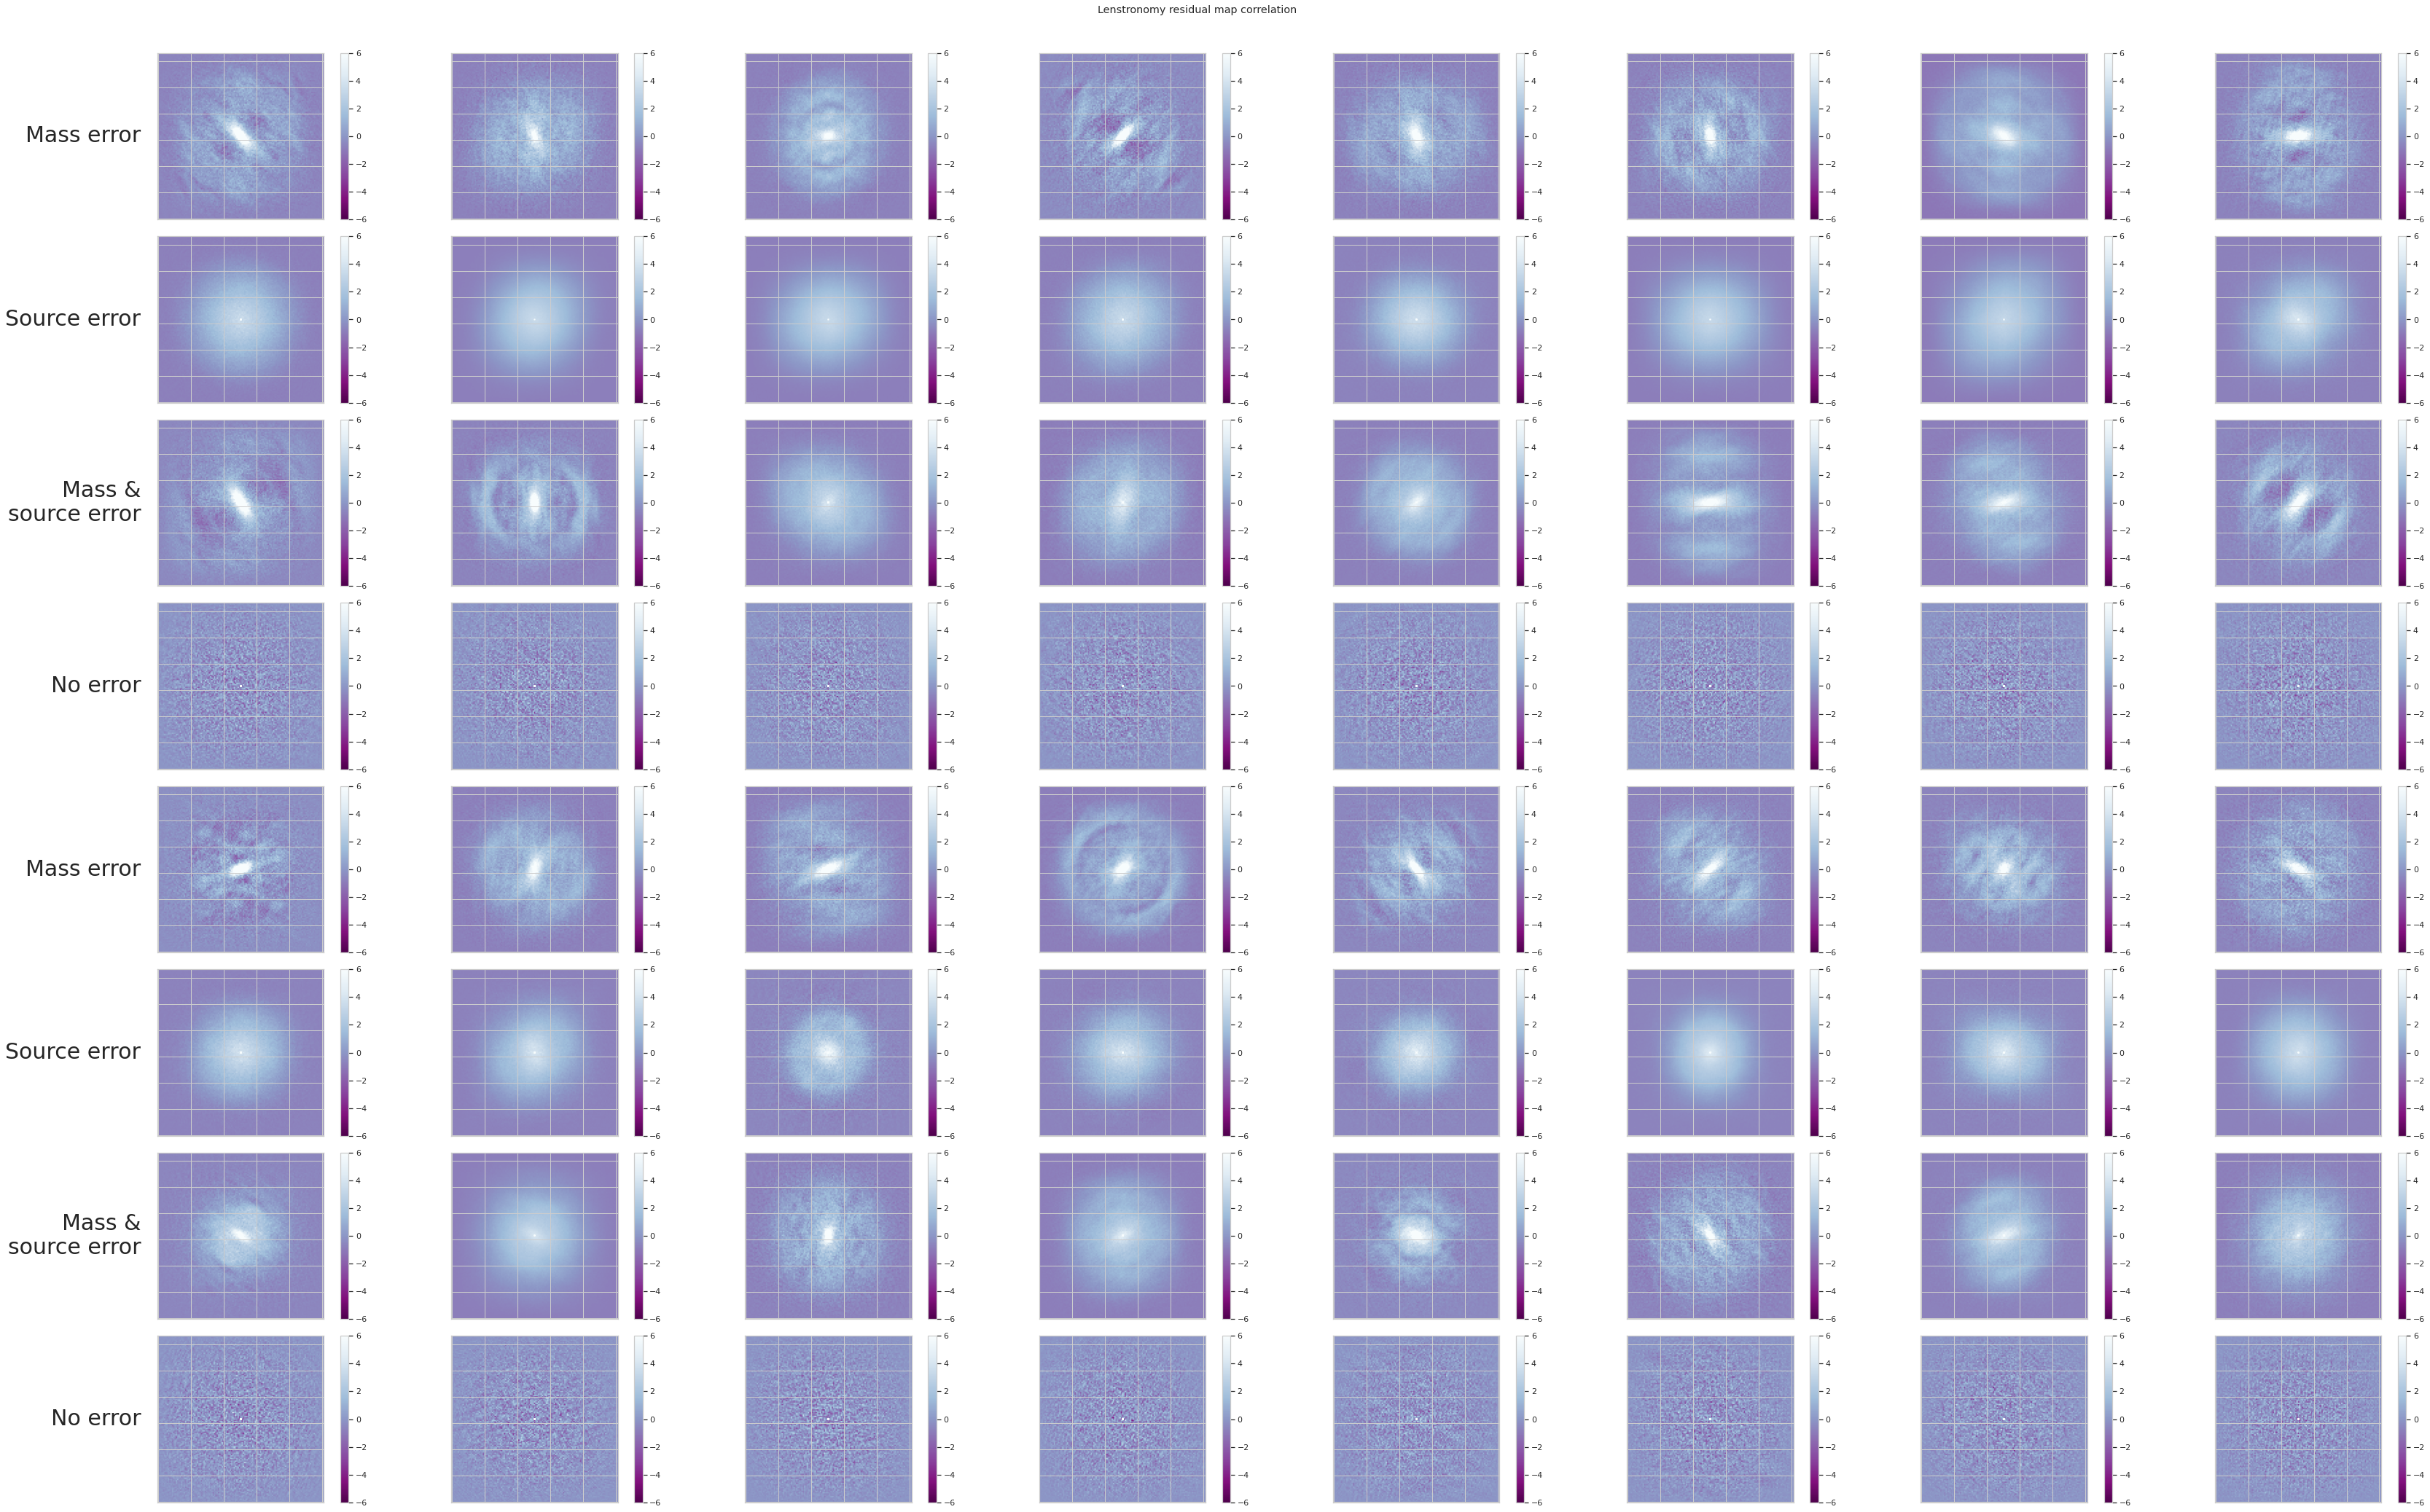

In [5]:
from scipy import signal
cor = signal.correlate2d (final_array[indices_mass[0],0,:,:], final_array[indices_mass[0],0,:,:])

f, axes = plt.subplots(8, 8, figsize=(48, 30), sharex=False, sharey=False)
ran = 6
for count, k in enumerate(np.array([0, 4,])):
    for i in range(0,8):
        cor_mass = signal.correlate2d (final_array[indices_mass[i+9*count],0,:,:], final_array[indices_mass[i+9*count],0,:,:])
        cor_source = signal.correlate2d (final_array[indices_source[i+9*count],0,:,:], final_array[indices_source[i+9*count],0,:,:])
        cor_sourcemass = signal.correlate2d (final_array[indices_masssource[i+9*count],0,:,:], final_array[indices_masssource[i+9*count],0,:,:])
        cor_noerror = signal.correlate2d (final_array[indices_noerror[i+9*count],0,:,:], final_array[indices_noerror[i+9*count],0,:,:])
        cor_mass = (cor_mass- np.mean(cor_mass))/np.std(cor_mass)
        cor_source = (cor_source- np.mean(cor_source))/np.std(cor_source)
        cor_sourcemass = (cor_sourcemass- np.mean(cor_sourcemass))/np.std(cor_sourcemass)
        cor_noerror = (cor_noerror- np.mean(cor_noerror))/np.std(cor_noerror)
        pos1 = axes[k,i].imshow(cor_mass,  vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)
        pos2 = axes[k+1,i].imshow(cor_source,  vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)
        pos3 = axes[k+2,i].imshow(cor_sourcemass, vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)
        pos4 = axes[k+3,i].imshow(cor_noerror, vmin=-ran, vmax=ran, origin='lower',cmap=plt.cm.BuPu_r)

        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        axes[k+1,i].set_yticklabels([]); axes[k+1,i].set_xticklabels([])
        axes[k+2,i].set_yticklabels([]); axes[k+2,i].set_xticklabels([])
        axes[k+3,i].set_yticklabels([]); axes[k+3,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i]); f.colorbar(pos2, ax=axes[k+1,i]); f.colorbar(pos3, ax=axes[k+2,i]); f.colorbar(pos4, ax=axes[k+3,i])
    
    
    pad = 5
    font = 30

    axes[k,0].annotate('Mass error', xy=(0, 0.5), xytext=(-axes[k,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+1,0].annotate('Source error', xy=(0, 0.5), xytext=(-axes[k+1,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+1,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+2,0].annotate('Mass &\nsource error', xy=(0, 0.5), xytext=(-axes[k+2,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+2,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    
    axes[k+3,0].annotate('No error', xy=(0, 0.5), xytext=(-axes[k+3,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+3,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
f.suptitle('Lenstronomy residual map correlation', size = 'large')
plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()
f.savefig('figures/datanalysis/Autocorrelation_chi2.jpeg')

#### Residual maps without error

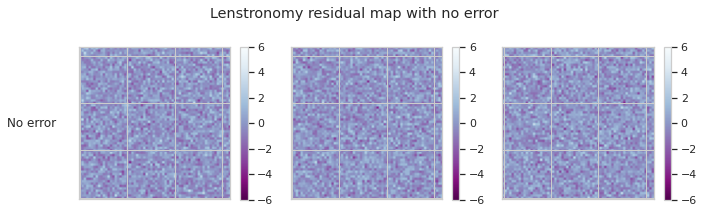

In [6]:
f, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)
index = metadata.index

indices_noerror = index[[col == [0,0] for col in metadata['class']]]

for i in range(3):
    pos = axes[i].imshow(final_array[indices_noerror[i],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)

    axes[i].set_yticklabels([]); axes[i].set_xticklabels([])
    f.colorbar(pos, ax=axes[i]);
    
pad = 5

axes[0].annotate('No error', xy=(0, 0.5), xytext=(-axes[0].yaxis.labelpad - pad, 0),
                   xycoords=axes[0].yaxis.label, textcoords='offset points', ha='right', va='center')

f.suptitle('Lenstronomy residual map with no error', size = 'large')
plt.tight_layout()
plt.show()

plt.show()
f.savefig('figures/datanalysis/Noerror_chi2.jpeg')

#### Simulated images 

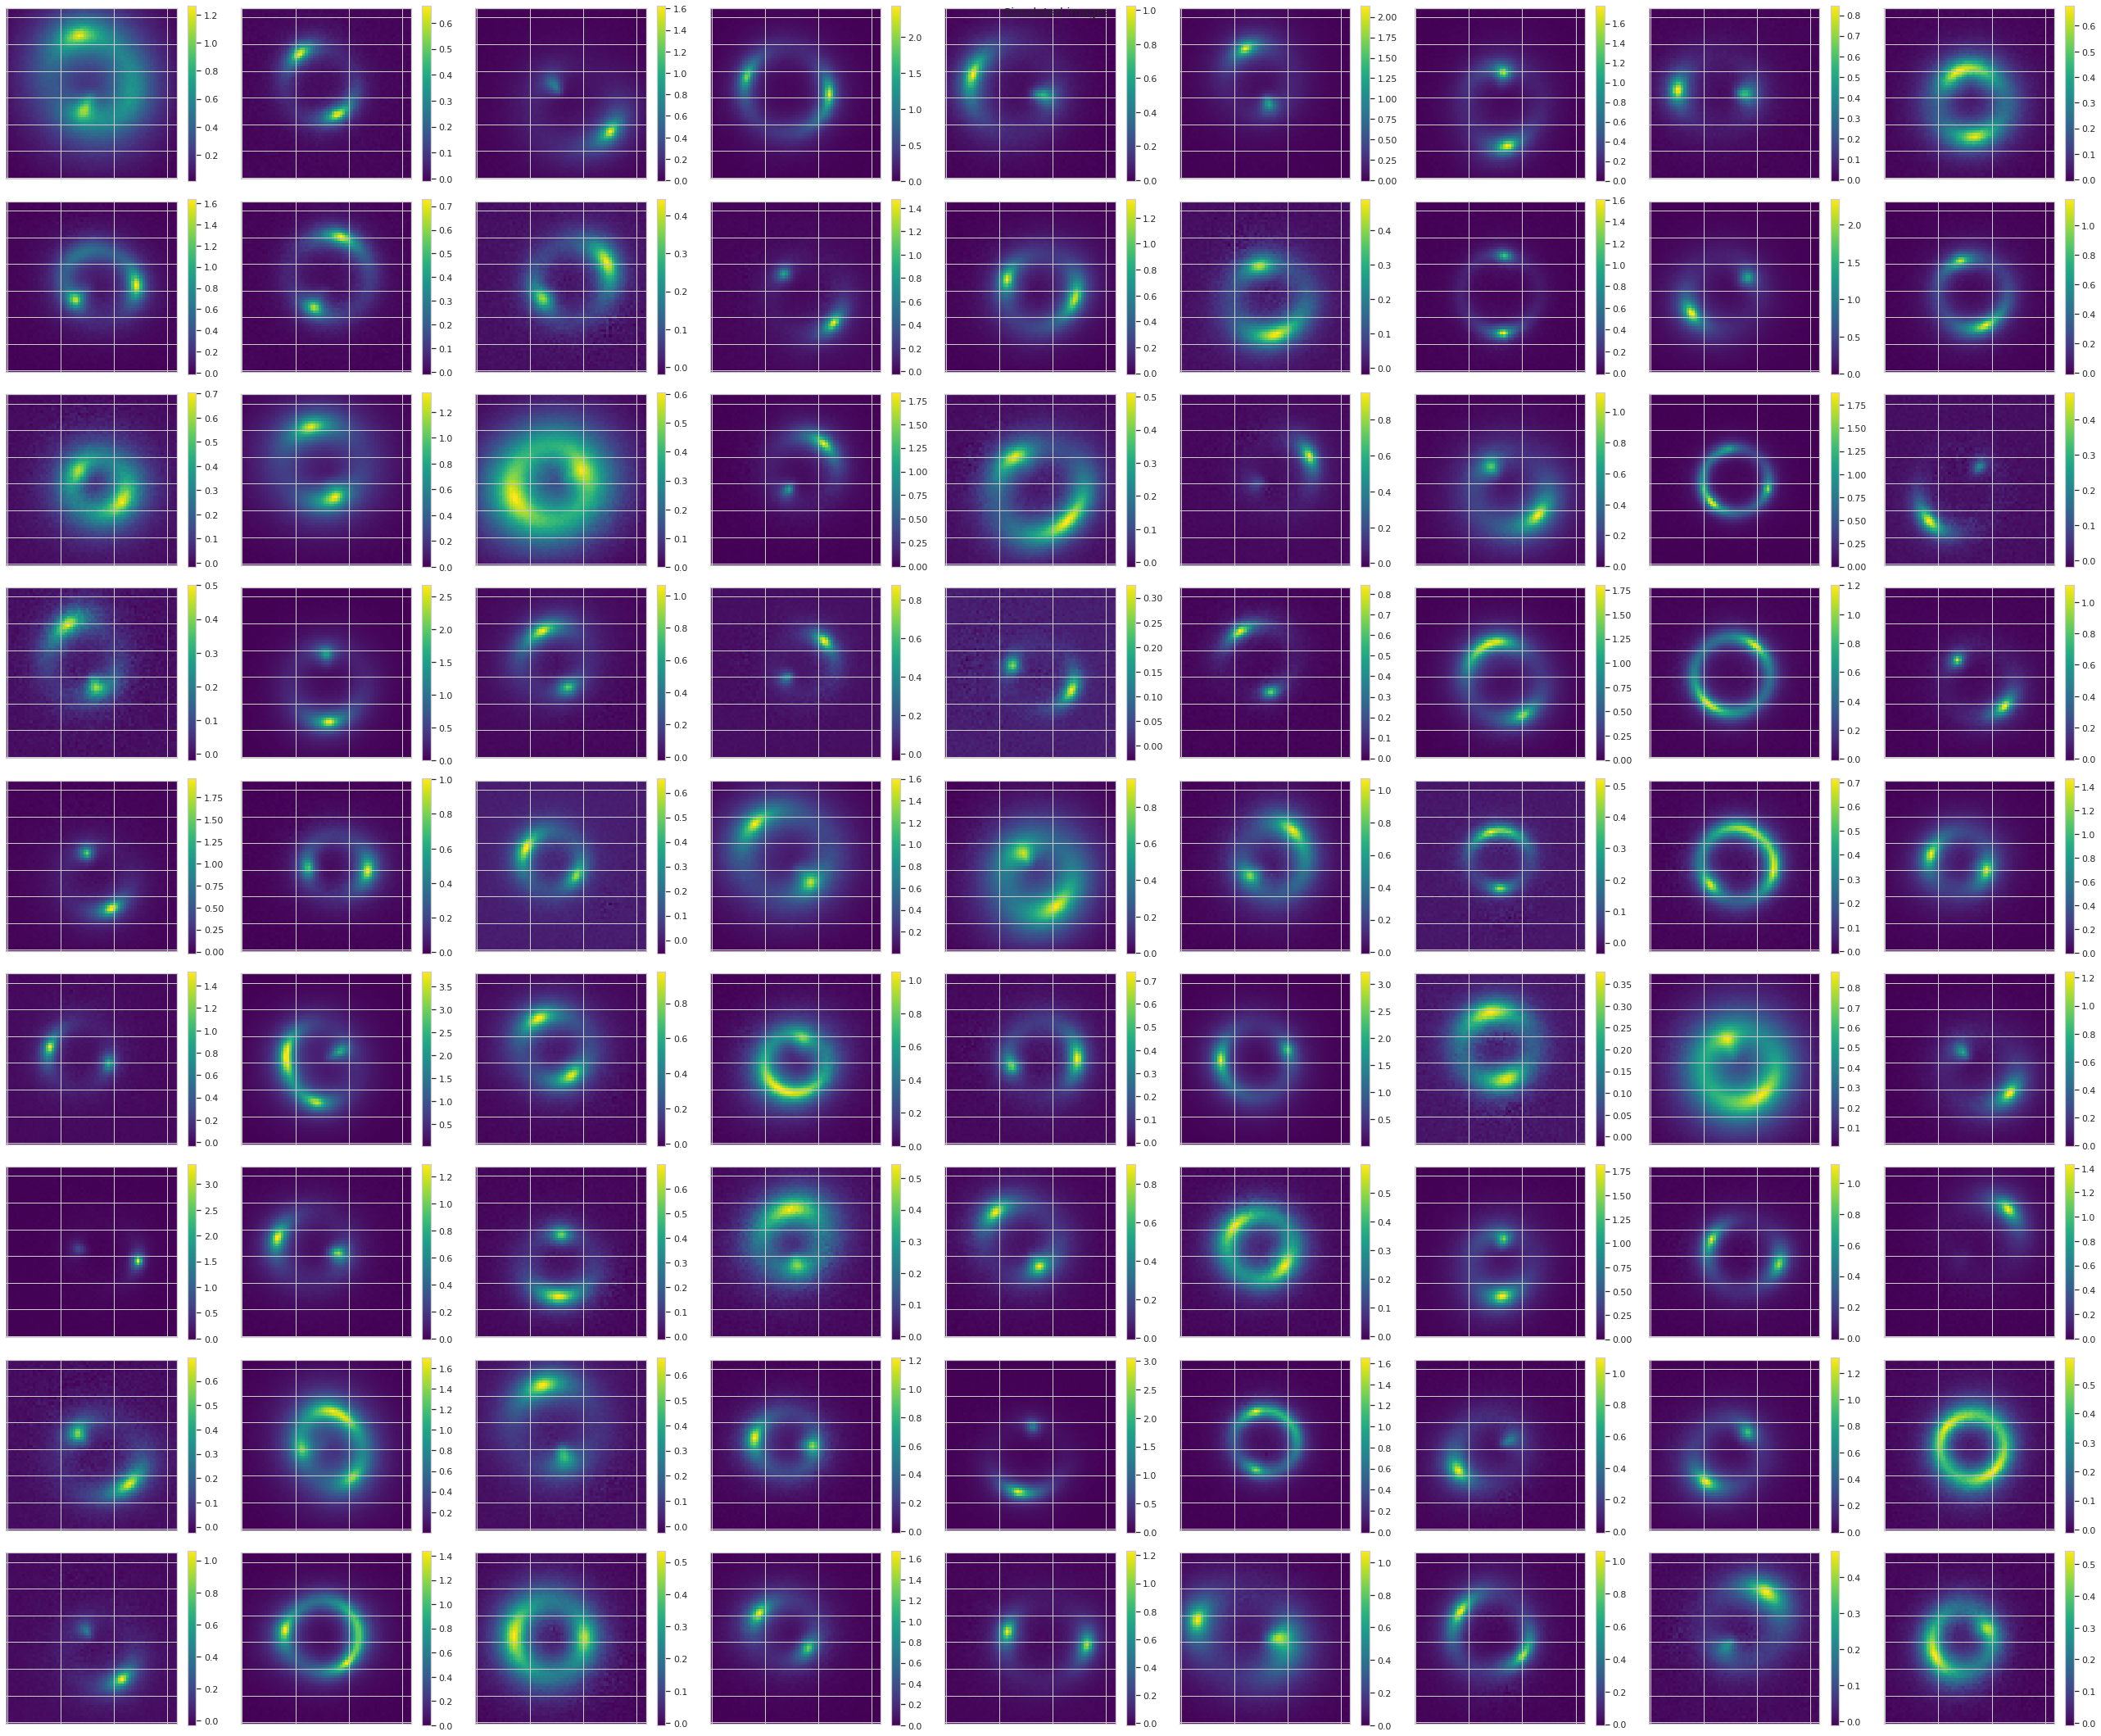

In [7]:
f, axes = plt.subplots(9, 9, figsize=(36, 30), sharex=False, sharey=False)
dataset_model = LensDataset(size = size, percent = percent)
p_decal = 10

for i in range(0,9):
    for k in range(9):
        
        image_real = dataset_model.images[i+k*p_decal][0] + dataset_model.image_config.noise_for_model(model = dataset_model.images[i][0])
        pos1 = axes[k,i].imshow(image_real, cmap = 'viridis', origin='lower')
        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i])

f.suptitle('Simulated images', size = 'large')
f.tight_layout()
plt.show()

plt.show()
f.savefig('figures/datanalysis/simulated_chi2.jpeg')

## 3. Plot distributions

### 3.1 Label distribution
Plot the distribution of each label for a $ratio = 0.75$ of error. The ratio corresponds to the per cent of data that does not correspond to the data with no errors (label = (0,0)).

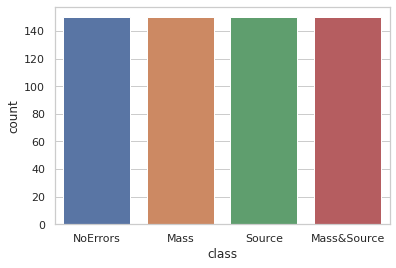

In [8]:
meta_dist = metadata.copy(deep=True)
meta_dist.loc[[col == [0,0] for col in meta_dist['class']], 'class'] = 'NoErrors'
meta_dist.loc[[col == [1,0] for col in meta_dist['class']], 'class'] = 'Mass'
meta_dist.loc[[col == [0,1] for col in meta_dist['class']], 'class'] = 'Source'
meta_dist.loc[[col == [1,1] for col in meta_dist['class']], 'class'] = 'Mass&Source'

ax = sns.countplot(meta_dist['class'],label="Count")
fig = ax.get_figure()

fig.savefig('figures/datanalysis/balancelabel_chi2.jpeg')

### 3.2 Parameters distribution according to error
The first plot corresponds to the statistical distribution of mass error data, which consider mass error and mass and source error class. The remaining dataset is considered as data without mass error.

The second plot is the statistical distribution of the source error data. Similarly to the previous graph, only source errors are considered.

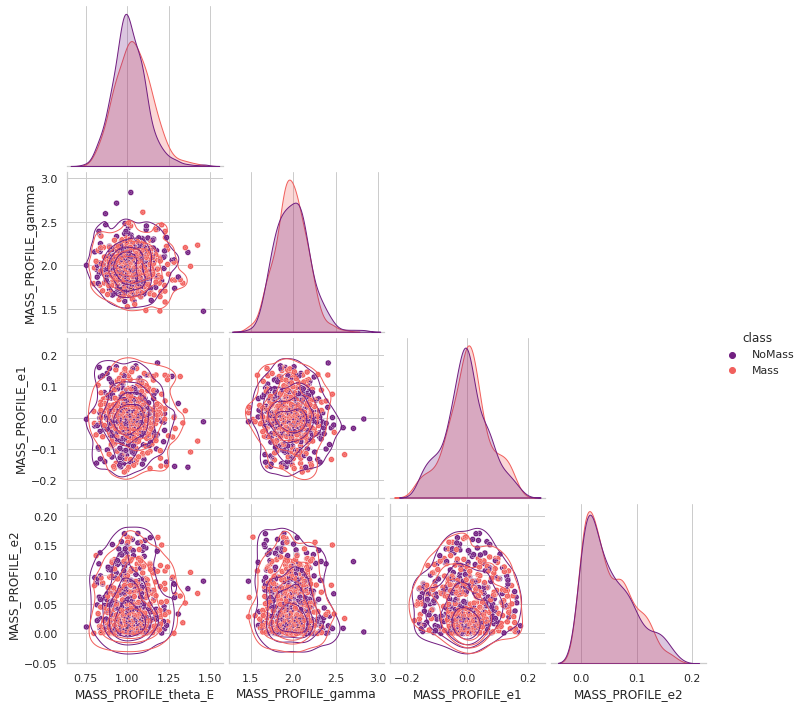

In [9]:
meta_err = res.metadata_error.copy(deep=True)

meta_err.loc[[col == [0,0] for col in meta_err['class']], 'class'] = 'NoMass'
meta_err.loc[[col == [1,0] for col in meta_err['class']], 'class'] = 'Mass'
meta_err.loc[[col == [0,1] for col in meta_err['class']], 'class'] = 'NoMass'
meta_err.loc[[col == [1,1] for col in meta_err['class']], 'class'] = 'Mass'

cols = meta_err.columns[2:6].tolist()
cols.append('class')
g = sns.pairplot(meta_err[cols], diag_kind="kde", corner = True, hue="class", palette = "magma")
g.map_lower(sns.scatterplot, s=5)
g.map_lower(sns.histplot, bins=300, pthresh=.1)
g.map_lower(sns.kdeplot, levels=5, color="w", linewidths=1)
g.savefig('figures/datanalysis/statMass_chi2.jpeg')

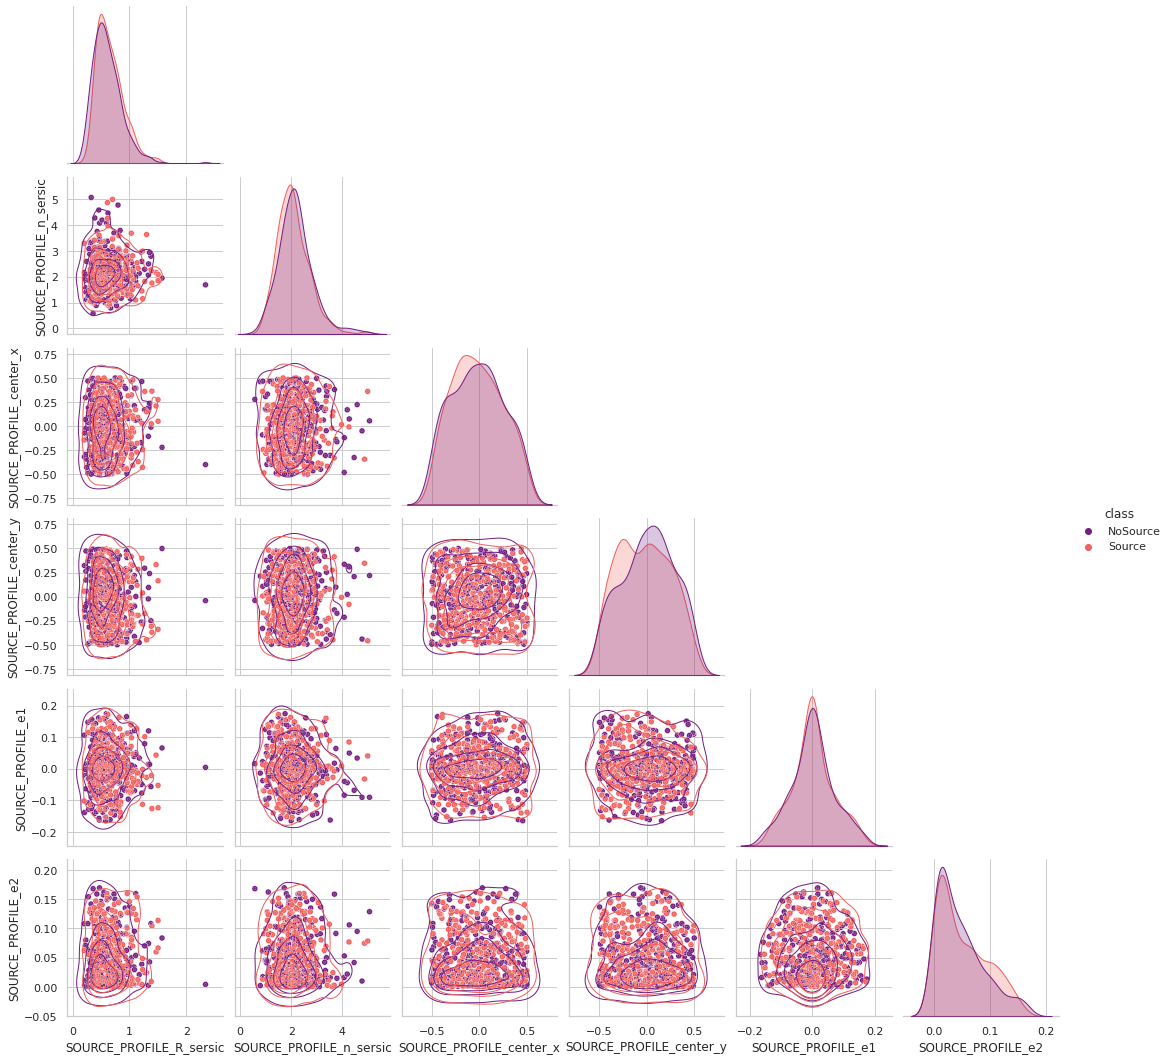

In [10]:
meta_err = res.metadata_error.copy(deep=True)

meta_err.loc[[col == [0,0] for col in meta_err['class']], 'class'] = 'NoSource'
meta_err.loc[[col == [1,0] for col in meta_err['class']], 'class'] = 'NoSource'
meta_err.loc[[col == [0,1] for col in meta_err['class']], 'class'] = 'Source'
meta_err.loc[[col == [1,1] for col in meta_err['class']], 'class'] = 'Source'
meta_err=meta_err.drop(columns=['percent'])


cols = meta_err.columns[7:].tolist()
g = sns.pairplot(meta_err[cols], diag_kind="kde", corner = True, hue="class", palette = "magma")
g.map_lower(sns.scatterplot, s=5)
g.map_lower(sns.histplot, bins=300, pthresh=.1)
g.map_lower(sns.kdeplot, levels=5, color="w", linewidths=1)
g.savefig('figures/datanalysis/statSource_chi2.jpeg')

### 3.3 Distribution of the distance between a image with an error & a image without error

Distance distribution for percentage $p = \begin{bmatrix}5\% & 1.5\% & 5\%\end{bmatrix}$. The first percentage is the mass error, the second the source error and the last the source and the mass error dataset. The distance is computed for a residual map that has no error.

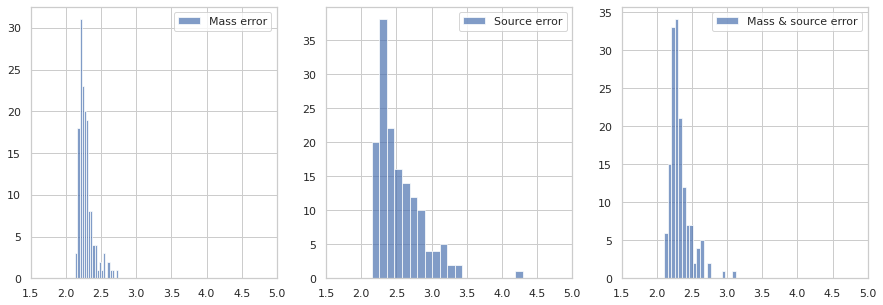

Mean distance of the mass : 2.285114626365845
Mean distance of the source : 2.5409013310421384
Mean distance of the mass & the source : 2.3273909676363957


In [11]:
dist_mass = [np.sum((final_array[indices_mass[i],0,:,:]-final_array[indices_noerror[i],0,:,:])**2)/64**2 for i in range(len(indices_noerror))]
dist_source = [np.sum((final_array[indices_source[i],0,:,:]-final_array[indices_noerror[i],0,:,:])**2)/64**2 for i in range(len(indices_noerror))]
dist_masssource = [np.sum((final_array[indices_masssource[i],0,:,:]-final_array[indices_noerror[i],0,:,:])**2)/64**2 for i in range(len(indices_noerror))]
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

axes[0].hist(dist_mass, label = 'Mass error', bins = 20, alpha=0.7)
axes[1].hist(dist_source, label = 'Source error',bins = 20, alpha=0.7)
axes[2].hist(dist_masssource, label = 'Mass & source error', bins = 20, alpha=0.7)
plt.setp(axes, xlim=(1.5, 5))
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.savefig('figures/datanalysis/distancefinal.jpeg')
plt.show()


print('Mean distance of the mass : '+ str(mean(dist_mass))+ '\nMean distance of the source : ' + str(mean(dist_source))+ 
      '\nMean distance of the mass & the source : ' +  str(mean(dist_masssource)))

### 3.4 Distribution of the Chi2 test
#### Chi square 

The Chi-square test is similar to the distance approach, yet instead of comparing with an image with no error that is noisy, the data is compared with a residual that is noiseless.

Chi2 mean of the mass : 1.2879759311942467
Chi2 mean of the source : 1.5415109915469611
Chi2 mean of the mass & the source : 1.3307601952303252
Chi2 mean of no error : 0.998878444658524


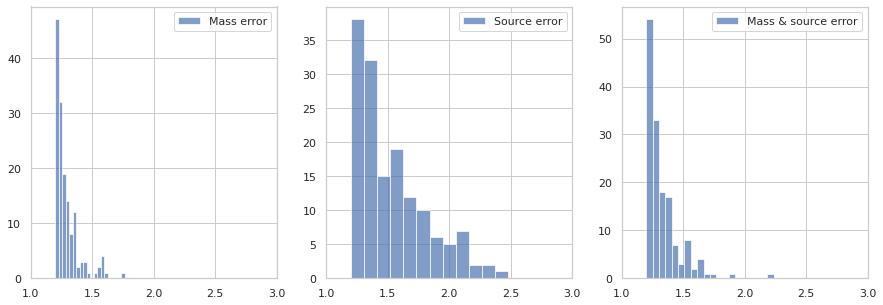

In [12]:
from scipy.stats import chi2, chi

ki2_noerror = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_noerror]
ki2_mass = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_mass]
ki2_source = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_source]
ki2_masssource = [np.sum(final_array[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_masssource]

print('Chi2 mean of the mass : '+ str(mean(ki2_mass))+ '\nChi2 mean of the source : ' + str(mean(ki2_source))+ 
      '\nChi2 mean of the mass & the source : ' +  str(mean(ki2_masssource))+ '\nChi2 mean of no error : ' + str(mean(ki2_noerror)))
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

axes[0].hist(ki2_mass, label = 'Mass error', bins = 20, alpha=0.7)
axes[1].hist(ki2_source, label = 'Source error',bins = 20, alpha=0.7)
axes[2].hist(ki2_masssource, label = 'Mass & source error', bins = 20, alpha=0.7)
plt.setp(axes, xlim=(1, 3))
axes[0].legend()
axes[1].legend()
axes[2].legend()
f.savefig('figures/datanalysis/Chi2final.jpeg')
f.show()

#### Chi square with noise consideration
In this case, the only unit of noise larger than three is considered to remove noise like error residuals.

Chi2 mean of the mass : 9.019802901192257
Chi2 mean of the source : 9.026879664603621
Chi2 mean of the mass & the source : 9.020801163030168
Chi2 mean of no error : 9.002572300123672


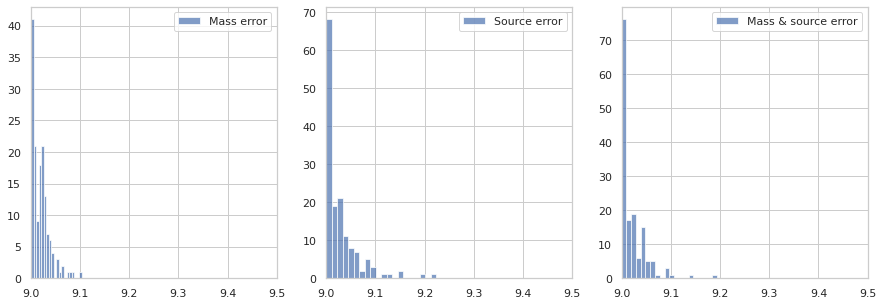

In [13]:
noise_final = final_array.clip(min=3)

ki2_noerror = [np.sum(noise_final[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_noerror]
ki2_mass = [np.sum(noise_final[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_mass]
ki2_source = [np.sum(noise_final[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_source]
ki2_masssource = [np.sum(noise_final[i,0,:,:]**2)/(final_array.shape[3]*final_array.shape[2])for i in indices_masssource]

print('Chi2 mean of the mass : '+ str(mean(ki2_mass))+ '\nChi2 mean of the source : ' + str(mean(ki2_source))+ 
      '\nChi2 mean of the mass & the source : ' +  str(mean(ki2_masssource))+ '\nChi2 mean of no error : ' + str(mean(ki2_noerror)))
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)


axes[0].hist(ki2_mass, label = 'Mass error', bins = 20, alpha=0.7)
axes[1].hist(ki2_source, label = 'Source error',bins = 20, alpha=0.7)
axes[2].hist(ki2_masssource, label = 'Mass & source error', bins = 20, alpha=0.7)
plt.setp(axes, xlim=(9, 9.5))
axes[0].legend()
axes[1].legend()
axes[2].legend()
f.savefig('figures/datanalysis/Chi2Noisefinal.jpeg')
f.show()

### 3.5 Test on several percentage
Several percentages are tested to see if there is a correlation between the proposed metrics and the distribution of the data set.
The tested percentages are :


Distance :
>$p_1 = \begin{bmatrix}5\% & 1.42\% & 4.9\%\end{bmatrix}$

Chi2 :
>$p_2 = \begin{bmatrix}5\% & 1.42\% & 5\%\end{bmatrix}$

Baseline: This percentage shows similar results for the source and mass label classification, yet it is found from trial and error, which is not a viable method.
>$p_3 = \begin{bmatrix}7.4\% & 1.5\% & 2.5\%\end{bmatrix}$


This approach concludes that a study of the distribution between each quantity is insufficient to process how the neural network perceives the task. Moreover, the classification tasks have probably different outcomes depending on the neural network architecture.

#### Distance distribution
The distance is computed for a residual map that has no error.

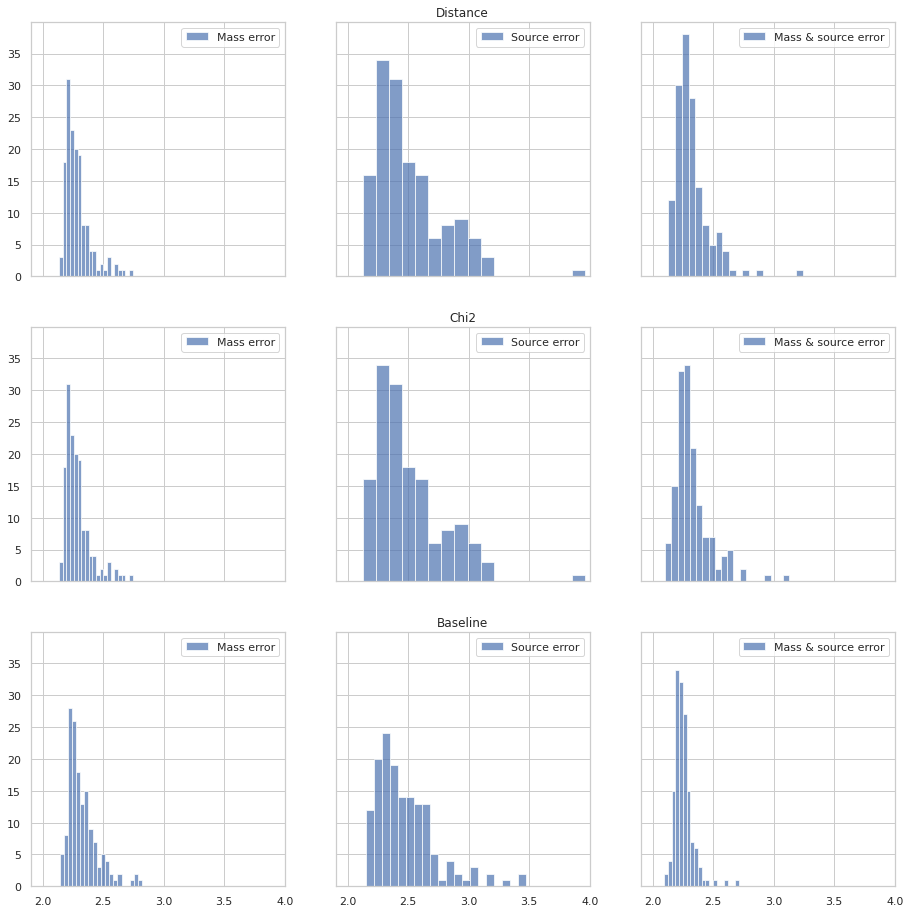

In [18]:
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex='all', sharey='all',
                       gridspec_kw=dict(left=0.1, right=0.9,bottom=0.1, top=0.9))
percent = np.array([[0.005, 0.0142, 0.0049], [0.005, 0.0142, 0.005], [0.0074, 0.015, 0.0025]])
size = 600; ratio = 0.75;

for ii in range(3):

    res = Residual()
    res.build(size, ratio = ratio, per_error = percent[ii,:])

    str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
    [final_array, metadata] = read_hdf5(str_ID)

    index = metadata.index

    indices_noerror = index[[col == [0,0] for col in metadata['class']]]
    indices_mass = index[[col == [1,0] for col in metadata['class']]]
    indices_source = index[[col == [0,1] for col in metadata['class']]]
    indices_masssource = index[[col == [1,1] for col in metadata['class']]]

    dist_mass = [np.sum((final_array[indices_mass[i],0,:,:]-final_array[indices_noerror[i],0,:,:])**2)/64**2 for i in range(len(indices_noerror))]
    dist_source = [np.sum((final_array[indices_source[i],0,:,:]-final_array[indices_noerror[i],0,:,:])**2)/64**2 for i in range(len(indices_noerror))]
    dist_masssource = [np.sum((final_array[indices_masssource[i],0,:,:]-final_array[indices_noerror[i],0,:,:])**2)/64**2 for i in range(len(indices_noerror))]
    
    dens_mass = gaussian_kde(dist_mass)
    dens_source = gaussian_kde(dist_source)
    dens_masssource = gaussian_kde(dist_masssource)
    
    y_mass = dens_mass(np.linspace(1.5,5,200))
    y_source = dens_source(np.linspace(1.5,5,200))
    y_masssource = dens_masssource(np.linspace(1.5,5,200))
    
    axes[ii, 0].hist(dist_mass, label = 'Mass error', bins = 20, alpha=0.7)
    axes[ii, 1].hist(dist_source, label = 'Source error',bins = 20, alpha=0.7)
    axes[ii, 2].hist(dist_masssource, label = 'Mass & source error', bins = 20, alpha=0.7)
    axes[ii,0].legend()
    axes[ii,1].legend()
    axes[ii,2].legend()
    
plt.setp(axes, xlim=(1.9, 4))    
axes[1,1].title.set_text('Chi2')
axes[0,1].title.set_text('Distance')
axes[2,1].title.set_text('Baseline')
plt.legend()
plt.savefig('figures/datanalysis/distance.jpeg')
plt.show()

#### Chi square distribution

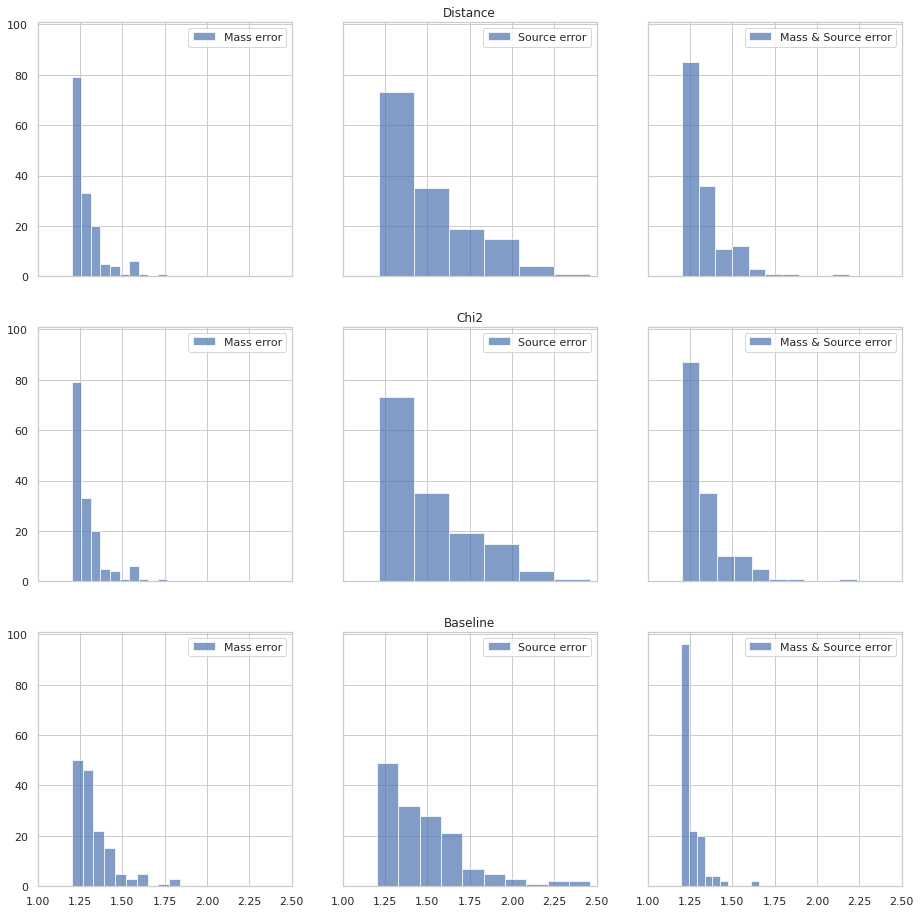

In [16]:
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex='all', sharey='all',
                       gridspec_kw=dict(left=0.1, right=0.9,bottom=0.1, top=0.9))
percent = np.array([[0.005, 0.0142, 0.0049], [0.005, 0.0142, 0.005], [0.0074, 0.015, 0.0025]])
ratio = 0.75; size = 600

for ii in range(3):

    res = Residual()
    res.build(size, ratio = ratio, per_error = percent[ii,:])

    str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
    [final_array, metadata] = read_hdf5(str_ID)

    index = metadata.index

    indices_noerror = index[[col == [0,0] for col in metadata['class']]]
    indices_mass = index[[col == [1,0] for col in metadata['class']]]
    indices_source = index[[col == [0,1] for col in metadata['class']]]
    indices_masssource = index[[col == [1,1] for col in metadata['class']]]

    ki2_noerror = [np.sum(final_array[i,:,:]**2)/(final_array.shape[2]*final_array.shape[3])for i in indices_noerror]
    ki2_mass = [np.sum(final_array[i,:,:]**2)/(final_array.shape[2]*final_array.shape[3])for i in indices_mass]
    ki2_source = [np.sum(final_array[i,:,:]**2)/(final_array.shape[2]*final_array.shape[3])for i in indices_source]
    ki2_masssource = [np.sum(final_array[i,:,:]**2)/(final_array.shape[2]*final_array.shape[3])for i in indices_masssource]
    
    
    axes[ii, 0].hist(ki2_mass, label = 'Mass error', alpha=0.7)
    axes[ii, 1].hist(ki2_source, label = 'Source error', alpha=0.7)
    axes[ii, 2].hist(ki2_masssource, label = 'Mass & Source error', alpha=0.7)
    axes[ii,0].legend(); axes[ii,1].legend(); axes[ii,2].legend(); 
    
axes[2, 1].title.set_text('Baseline')
axes[1, 1].title.set_text('Chi2')
axes[0, 1].title.set_text('Distance')
plt.setp(axes, xlim=(1, 2.5))   
plt.show()